In [1]:
import geopandas as gpd, pandas as pd, rasterio as rio, json,  numpy as np, matplotlib.pyplot as plt, math
from rasterio.transform import from_origin
from rasterio.features import rasterize
from rasterio.enums import Resampling
from rasterio.transform import rowcol
from shapely.geometry import Polygon
from scipy.integrate import odeint
from shapely.geometry import Point
from rasterio.plot import show
from rasterio.mask import mask

### Raster ballistic trajectory 360° with wind influence

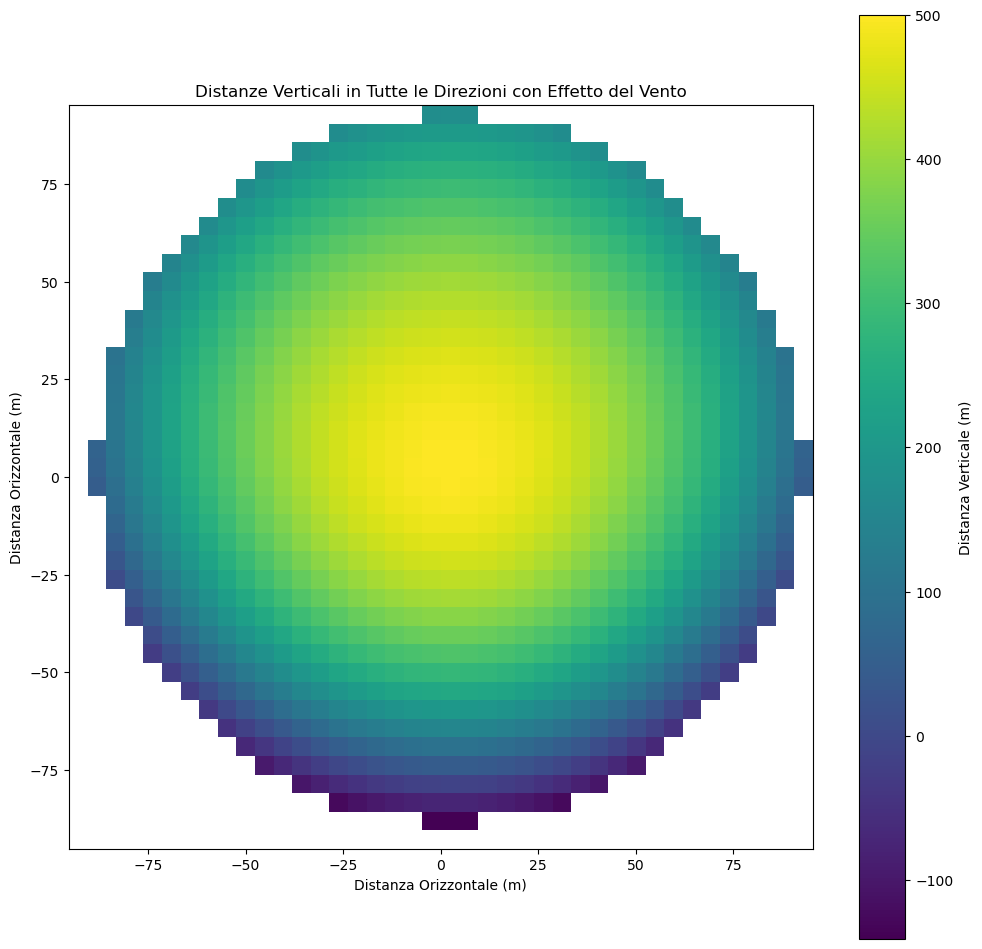

In [2]:
# Funzione per trasformare le coordinate geografiche in coordinate del raster
def transform_coordinates(x, y, raster):
    row, col = raster.index(x, y)  # Trasforma le coordinate geografiche in coordinate del raster
    return row, col

# Funzione per leggere i dati del vento dai raster
def get_wind_data(x, y, wind_speed_raster_path, wind_direction_raster_path):
    with rio.open(wind_speed_raster_path) as wind_speed_raster:
        wind_speed_row, wind_speed_col = transform_coordinates(x, y, wind_speed_raster)
        wind_speed = wind_speed_raster.read(1)[wind_speed_row, wind_speed_col]

    with rio.open(wind_direction_raster_path) as wind_direction_raster:
        wind_direction_row, wind_direction_col = transform_coordinates(x, y, wind_direction_raster)
        wind_direction = wind_direction_raster.read(1)[wind_direction_row, wind_direction_col]

    return wind_speed, wind_direction

# Percorsi ai file raster del vento
wind_speed_raster_path = 'Storico meteo/Raster_export/predicted_B11002_1_Interval_1-15.tif'
wind_direction_raster_path = 'Storico meteo/Raster_export/predicted_B11002_1_Interval_1-15.tif'

# Carica il raster DEM e ottieni la risoluzione spaziale e le coordinate centrali
file_raster = 'Buildings_data/Parma_DEM_plus_buildings_raster_mask_5m.tif'
with rio.open(file_raster) as src:
    risoluzione_spaziale = src.res[0]
    profile = src.profile
    centro_raster_x, centro_raster_y = src.width // 2, src.height // 2
    centro_geo = src.xy(centro_raster_y, centro_raster_x)  # Coordinate geografiche del centro
    crs = src.crs

# Crea un GeoDataFrame con le informazioni del centro
gdf = gpd.GeoDataFrame({'id': [1]}, crs=crs, geometry=[Point(centro_geo[0], centro_geo[1])])
output_shp = 'output_centro_dem.shp'
gdf.to_file(output_shp)  # Salva il GeoDataFrame in un file shapefile

# Estrai la velocità e la direzione del vento usando le coordinate geografiche del centro
wind_speed, wind_direction = get_wind_data(centro_geo[0], centro_geo[1], wind_speed_raster_path, wind_direction_raster_path)

# Converti la velocità del vento in una componente orizzontale
wind_speed_x = wind_speed * np.cos(np.radians(wind_direction))

# Costanti e condizioni iniziali per la traiettoria balistica
m = 1.0  # Massa del drone (kg)
g = 9.81  # Accelerazione gravitazionale (m/s^2)
c = 0.1  # Coefficiente di resistenza
vxi = 10  # Velocità orizzontale iniziale (m/s)
altitude_base = 500  # Altitudine iniziale del drone (m)
dt = 0.01  # Intervallo di tempo per la simulazione
limite_distanza_verticale = -2000  # Limite di distanza verticale (es. -300 metri)

# Funzioni di velocità e posizione aggiornate per includere l'effetto del vento
def vx_wind(t, wind_speed_x, angle):
    wind_component = wind_speed_x * np.cos(np.radians(angle))
    return (vxi + wind_component) * np.exp(-c/m * t)

def y_adjusted(t, elevazione_iniziale):
    return altitude_base + elevazione_iniziale - 0.5 * g * t**2

# Calcolo della traiettoria balistica con l'effetto del vento
time = 0
x_total, y_total_adjusted = 0, altitude_base
x_positions = []

while y_total_adjusted > limite_distanza_verticale:
    angle = np.degrees(np.arctan2(y_total_adjusted - altitude_base, x_total)) if x_total != 0 else 90
    time += dt
    x_total += vx_wind(time, wind_speed_x, angle) * dt
    y_total_adjusted = y_adjusted(time, 0)  # Elevazione iniziale è zero
    x_positions.append(x_total)

# Massima distanza orizzontale raggiunta
max_distanza_orizzontale = max(x_positions)

# Calcolo delle dimensioni della matrice basate sulla risoluzione spaziale
dimensione_matrice_orizzontale = int(np.ceil(max_distanza_orizzontale / risoluzione_spaziale))
dimensione_matrice = 2 * dimensione_matrice_orizzontale

# Creazione della matrice delle distanze con l'effetto del vento
matrice_distanze = np.full((dimensione_matrice, dimensione_matrice), np.nan)
centro = dimensione_matrice // 2

epsilon = 1e-6  # Un piccolo valore per evitare la divisione per zero

for i in range(dimensione_matrice):
    for j in range(dimensione_matrice):
        dx = (i - centro) * risoluzione_spaziale
        dy = (j - centro) * risoluzione_spaziale
        distanza_orizzontale = np.sqrt(dx**2 + dy**2)
        angle = np.degrees(np.arctan2(dy, dx)) if distanza_orizzontale != 0 else 0

        if distanza_orizzontale <= max_distanza_orizzontale:
            velocità_orizzontale = max(vx_wind(0, wind_speed_x, angle), epsilon)
            t = distanza_orizzontale / velocità_orizzontale
            distanza_verticale = y_adjusted(t, 0)
            matrice_distanze[i, j] = distanza_verticale

# Visualizzazione della matrice
plt.figure(figsize=(12, 12))
plt.imshow(
    matrice_distanze,
    origin='lower',
    extent=[-max_distanza_orizzontale, max_distanza_orizzontale, -max_distanza_orizzontale, max_distanza_orizzontale],
    cmap='viridis'
)
plt.colorbar(label='Distanza Verticale (m)')
plt.xlabel('Distanza Orizzontale (m)')
plt.ylabel('Distanza Orizzontale (m)')
plt.title('Distanze Verticali in Tutte le Direzioni con Effetto del Vento')
plt.grid(False)
plt.show()

In [3]:
# Percorso del file di output
output_raster = "matrice_distanze.tif"

# Ottieni il trasform (affine transform) appropriato per il nuovo raster
# Calcola l'angolo in alto a sinistra in coordinate geografiche
upper_left_x = centro_geo[0] - dimensione_matrice_orizzontale * risoluzione_spaziale / 2
upper_left_y = centro_geo[1] + dimensione_matrice_orizzontale * risoluzione_spaziale / 2

# Crea il transform per il nuovo raster
transform = from_origin(upper_left_x, upper_left_y, risoluzione_spaziale, risoluzione_spaziale)

# Definisci un nuovo profilo
new_profile = profile.copy()
new_profile.update({
    'driver': 'GTiff',
    'height': matrice_distanze.shape[0],
    'width': matrice_distanze.shape[1],
    'transform': transform,
    'dtype': rio.float32,
    'count': 1
})

# Scrivi la matrice nel nuovo raster
with rio.open(output_raster, 'w', **new_profile) as dst:
    dst.write(matrice_distanze.astype(rio.float32), 1)

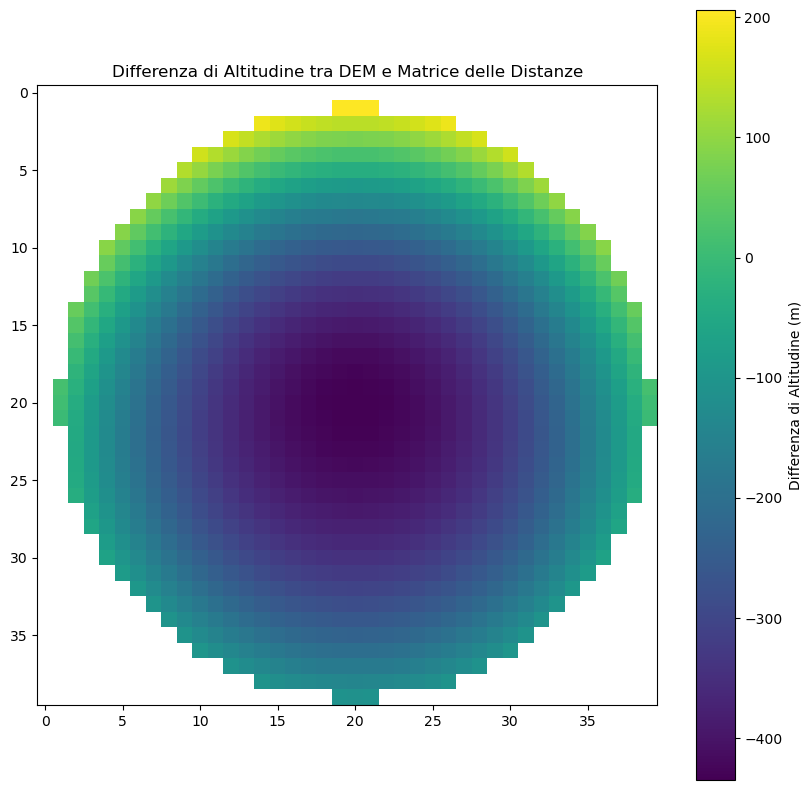

In [4]:
# Carica la DEM
file_raster_dem = 'Buildings_data/Parma_DEM_plus_buildings_raster_mask_5m.tif' # Sostituisci con il percorso corretto al file DEM
with rio.open(file_raster_dem) as src:
    dem_data = src.read(1)  # Legge il primo layer della DEM
    nodata = src.nodata  # Valore di nodata

# Calcolo degli offset per allineare le matrici
offset_x = centro_raster_x - matrice_distanze.shape[1] // 2
offset_y = centro_raster_y - matrice_distanze.shape[0] // 2

# Creazione della matrice di sottrazione
sottrazione_matrice = np.full(matrice_distanze.shape, np.nan)

# Sottrai la matrice_distanze dalla DEM solo dove sovrappongono
for i in range(matrice_distanze.shape[0]):
    for j in range(matrice_distanze.shape[1]):
        dem_x = j + offset_x
        dem_y = i + offset_y
        if 0 <= dem_x < dem_data.shape[1] and 0 <= dem_y < dem_data.shape[0]:
            if not np.isnan(matrice_distanze[i, j]):
                valore_dem = dem_data[dem_y, dem_x] if dem_data[dem_y, dem_x] != nodata else 0
                sottrazione_matrice[i, j] = valore_dem - matrice_distanze[i, j]

# Visualizzazione della matrice risultante
plt.figure(figsize=(10, 10))
plt.imshow(sottrazione_matrice, cmap='viridis', vmin=np.nanmin(sottrazione_matrice), vmax=np.nanmax(sottrazione_matrice))
plt.colorbar(label='Differenza di Altitudine (m)')
plt.title('Differenza di Altitudine tra DEM e Matrice delle Distanze')
plt.show()

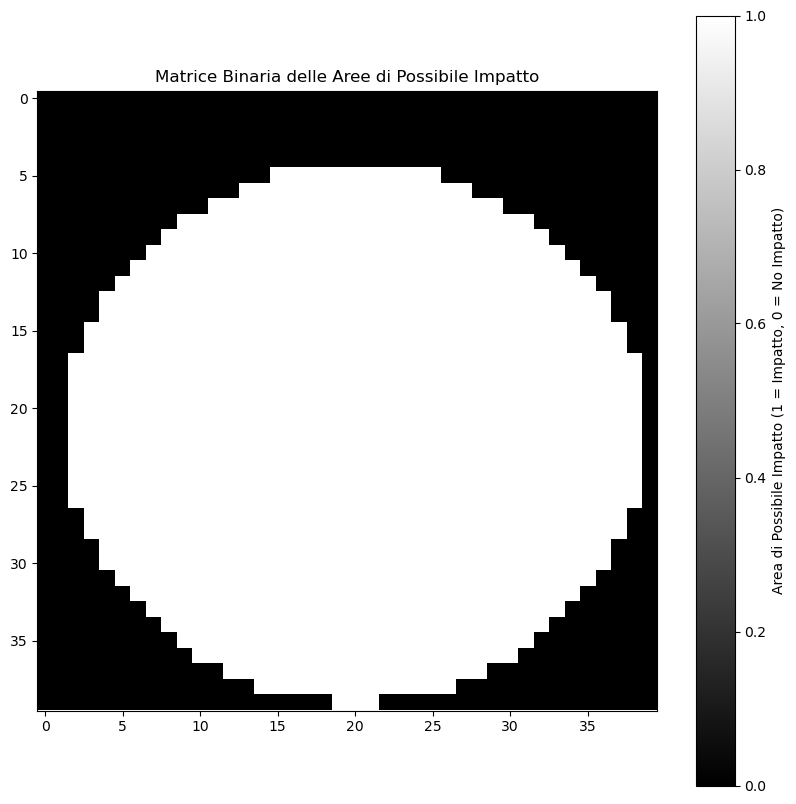

In [5]:
# Creazione della matrice binaria
matrice_binaria = np.where(sottrazione_matrice < 0, 1, 0)

# Visualizzazione della matrice binaria
plt.figure(figsize=(10, 10))
plt.imshow(matrice_binaria, cmap='gray')
plt.colorbar(label='Area di Possibile Impatto (1 = Impatto, 0 = No Impatto)')
plt.title('Matrice Binaria delle Aree di Possibile Impatto')
plt.show()